<a href="https://colab.research.google.com/github/kzumreen/FoodTrendsPrediction/blob/main/Reddit_Access.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install praw pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 4.9 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
import praw
import time
import pandas as pd

In [3]:
CLIENT_ID = userdata.get("REDDIT_CLIENT_ID")
CLIENT_SECRET = userdata.get("REDDIT_CLIENT_SECRET")
USER_AGENT = userdata.get("REDDIT_USER_AGENT")

In [4]:
try:
    reddit = praw.Reddit(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        user_agent=USER_AGENT
    )
    print("PRAW connection successful. Operating in read-only mode.")
except Exception as e:
    print(f"An error occurred during PRAW initialization: {e}")
    reddit = None

PRAW connection successful. Operating in read-only mode.


In [5]:
def get_subreddit_data(subreddit_name, limit=500):
    """Fetches the top 'limit' posts from a subreddit for all time."""

    if reddit is None:
        return []

    subreddit = reddit.subreddit(subreddit_name)
    print(f"\nFetching top {limit} posts from r/{subreddit_name}...")

    posts_data = []

    # Fetch top posts of all time
    for submission in subreddit.top(time_filter='all', limit=limit):
        posts_data.append({
            'id': submission.id,
            'subreddit': subreddit_name,
            'title': submission.title,
            'score': submission.score,
            'num_comments': submission.num_comments,
            'author': str(submission.author), # Converts Author object to string username
            'url': submission.url,
            'created_utc': submission.created_utc,
            'is_self_post': submission.is_self
        })

    print(f"Extraction complete. Found {len(posts_data)} posts.")
    return posts_data

In [6]:
# --- 4. RUN ANALYSIS FOR FOOD TRENDS ---
if __name__ == "__main__":

    # Define the subreddits related to food trends
    # NOTE: I have corrected 'r/unpopularopnionr/uk_food' to two separate subs,
    # and 'r,snacks' to 'r/snacks' for PRAW to correctly parse them.
    target_subreddits = [
        'food', 'cooking', 'recipes', 'baking', 'streetfood',
        'easyrecipes', 'snacksindia', 'askUK', 'candy', 'chocolate',
        'UAE', 'seriouseats', 'RecipeInspiration', 'unpopularopinion',
        'uk_food', 'cookingtonight', 'pasta', 'foodhack', 'nutrition',
        'vegetarianrecipes', 'foodvideos', 'budgetcooking', 'dessertporn',
        'junkfoodfinds', 'popculturechat', 'tea', 'shittyfoodporn',
        'snacks', 'foodlosangeles', 'stupidfood', 'TikTokTrends',
        'TikTokCringe'
    ]

    all_data = []

    # Fetch data for all target subreddits
    for sub in target_subreddits:
        posts = get_subreddit_data(sub, limit=500) # Get 500 top posts per sub
        all_data.extend(posts)

    # Convert the list of dictionaries into a DataFrame for analysis
    df = pd.DataFrame(all_data)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




Fetching top 500 posts from r/food...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/cooking...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/recipes...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/baking...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/streetfood...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/easyrecipes...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 249 posts.

Fetching top 500 posts from r/snacksindia...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/askUK...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/candy...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/chocolate...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/UAE...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 251 posts.

Fetching top 500 posts from r/seriouseats...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/RecipeInspiration...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 248 posts.

Fetching top 500 posts from r/unpopularopinion...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 246 posts.

Fetching top 500 posts from r/uk_food...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/cookingtonight...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/pasta...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 251 posts.

Fetching top 500 posts from r/foodhack...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/nutrition...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 249 posts.

Fetching top 500 posts from r/vegetarianrecipes...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 249 posts.

Fetching top 500 posts from r/foodvideos...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 248 posts.

Fetching top 500 posts from r/budgetcooking...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/dessertporn...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 249 posts.

Fetching top 500 posts from r/junkfoodfinds...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/popculturechat...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/tea...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/shittyfoodporn...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 249 posts.

Fetching top 500 posts from r/snacks...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/foodlosangeles...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 251 posts.

Fetching top 500 posts from r/stupidfood...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.

Fetching top 500 posts from r/TikTokTrends...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 122 posts.

Fetching top 500 posts from r/TikTokCringe...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Extraction complete. Found 250 posts.


In [10]:
# Convert the list of dictionaries into a DataFrame for analysis
df = pd.DataFrame(all_data)

df['date'] = pd.to_datetime(df['created_utc'], unit='s')
df = df.sort_values(by='date', ascending=False) # Sort newest first

# ==========================================================
# <<<<<<<<< INSERT NEW FILTERING CODE HERE >>>>>>>>>>>>
# ==========================================================

# 1. Define the start year and filter the main DataFrame
START_YEAR = 2015
df_filtered = df[df['date'].dt.year >= START_YEAR].copy()

# 2. Create the standardized Time_Period column (YYYY-MM-DD)
df_filtered['Time_Period'] = df_filtered['date'].dt.date.astype('datetime64[ns]')

# Now, replace the original 'df' with the filtered version for all subsequent analysis
df = df_filtered
print(f"\nData filtered: {len(df_filtered)} posts remaining (2015 to present).")

# ==========================================================

print("\n--- Initial Data Check (Top 5 Rows) ---")
# NOTE: The head now shows the new 'Time_Period' column
print(df[['subreddit', 'title', 'score', 'num_comments', 'date', 'Time_Period']].head())


Data filtered: 7795 posts remaining (2015 to present).

--- Initial Data Check (Top 5 Rows) ---
      subreddit                                              title  score  \
2298  chocolate                                My hoard for winter    633   
4211      pasta                                     Spicy Rigatoni    565   
3624    uk_food  Only posting this due to how proud I am of the...   1048   
6740     snacks              99 cents each and they’re packed full    119   
2569        UAE          Fans after the game between UAE and Qatar    615   

      num_comments                date Time_Period  
2298           147 2025-10-15 19:31:03  2025-10-15  
4211           117 2025-10-15 16:47:18  2025-10-15  
3624            98 2025-10-15 16:38:24  2025-10-15  
6740             7 2025-10-15 15:23:14  2025-10-15  
2569           177 2025-10-15 15:19:33  2025-10-15  


In [11]:
# Save the data to Google Drive (you'll need to mount drive in a separate cell if you want to save permanently)
    # df.to_csv('reddit_food_trend_data.csv', index=False)
print(f"\nSuccessfully collected {len(df)} total posts. Ready for analysis.")


Successfully collected 7795 total posts. Ready for analysis.


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7795 entries, 2298 to 462
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            7795 non-null   object        
 1   subreddit     7795 non-null   object        
 2   title         7795 non-null   object        
 3   score         7795 non-null   int64         
 4   num_comments  7795 non-null   int64         
 5   author        7795 non-null   object        
 6   url           7795 non-null   object        
 7   created_utc   7795 non-null   float64       
 8   is_self_post  7795 non-null   bool          
 9   date          7795 non-null   datetime64[ns]
 10  Time_Period   7795 non-null   datetime64[ns]
dtypes: bool(1), datetime64[ns](2), float64(1), int64(2), object(5)
memory usage: 677.5+ KB
None


In [14]:
print(df.isnull().sum())

id              0
subreddit       0
title           0
score           0
num_comments    0
author          0
url             0
created_utc     0
is_self_post    0
date            0
Time_Period     0
dtype: int64


In [15]:
print(df.describe())

               score  num_comments   created_utc  \
count    7795.000000   7795.000000  7.795000e+03   
mean     9189.771777    559.845029  1.666697e+09   
min         0.000000      0.000000  1.439294e+09   
25%       300.000000     16.000000  1.608218e+09   
50%       959.000000     78.000000  1.665593e+09   
75%      6971.000000    494.500000  1.735760e+09   
max    156296.000000  24376.000000  1.760557e+09   
std     17049.010751   1206.998876  6.892998e+07   

                                date                    Time_Period  
count                           7795                           7795  
mean   2022-10-25 11:22:16.302373376  2022-10-24 21:35:54.457985792  
min              2015-08-11 11:55:51            2015-08-11 00:00:00  
25%       2020-12-17 15:08:03.500000            2020-12-17 00:00:00  
50%              2022-10-12 16:49:11            2022-10-12 00:00:00  
75%       2025-01-01 19:30:18.500000            2025-01-01 00:00:00  
max              2025-10-15 19:31:03     

In [16]:
print(df.head())

           id  subreddit                                              title  \
2298  1o7kpzn  chocolate                                My hoard for winter   
4211  1o7ga9t      pasta                                     Spicy Rigatoni   
3624  1o7g1gf    uk_food  Only posting this due to how proud I am of the...   
6740  1o7e0hc     snacks              99 cents each and they’re packed full   
2569  1o7dwsl        UAE          Fans after the game between UAE and Qatar   

      score  num_comments                author  \
2298    633           147   AssistanceLucky2392   
4211    565           117       thehungryhustla   
3624   1048            98           Whydoucare-   
6740    119             7  Shot_Acanthaceae8127   
2569    615           177                 w204w   

                                       url   created_utc  is_self_post  \
2298  https://i.redd.it/6vcn2duuubvf1.jpeg  1.760557e+09         False   
4211       https://v.redd.it/jvkldzth1bvf1  1.760547e+09         False

<Axes: ylabel='subreddit'>

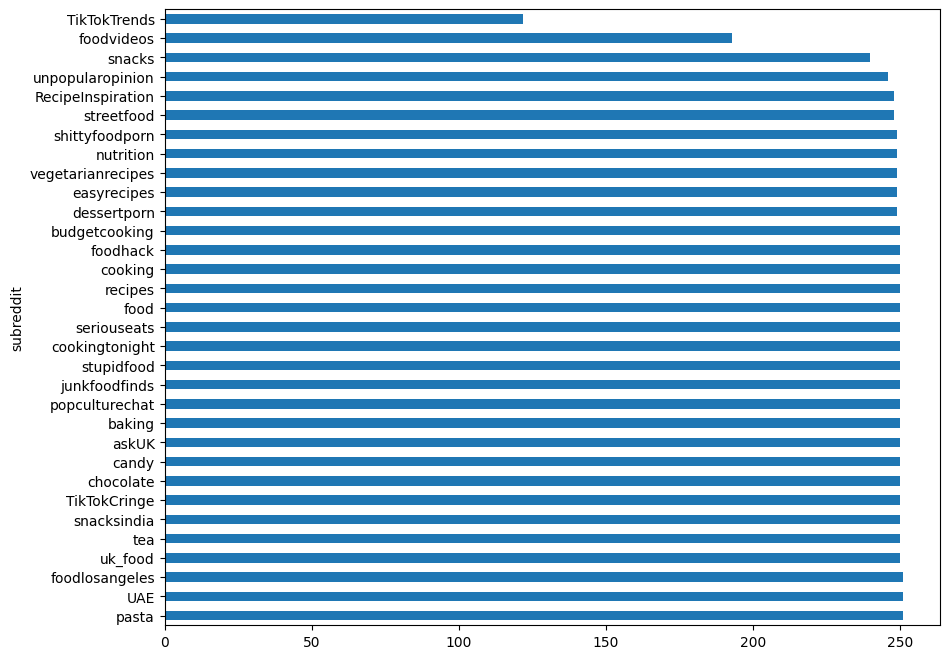

In [17]:
df['subreddit'].value_counts().plot(kind='barh', figsize=(10,8)) #which subreddits contributed the most

<Axes: >

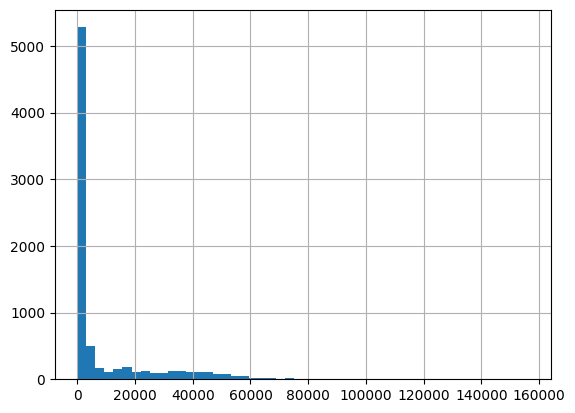

In [18]:
df['score'].hist(bins=50)

**Trend Analysis**

/tmp/ipython-input-2015624115.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('date').resample('M').size().plot() #how volume of top posts has changed over the years


<Axes: xlabel='date'>

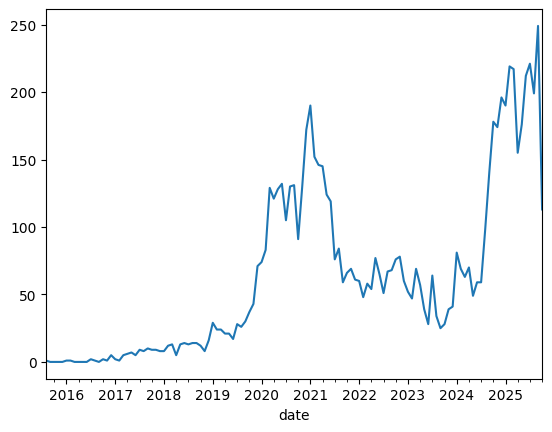

In [19]:
df.set_index('date').resample('M').size().plot() #how volume of top posts has changed over the years

/tmp/ipython-input-3937014089.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  air_fryer.set_index('date').resample('Y').size().plot(title='Air Fryer Mentions Over Time')


<Axes: title={'center': 'Air Fryer Mentions Over Time'}, xlabel='date'>

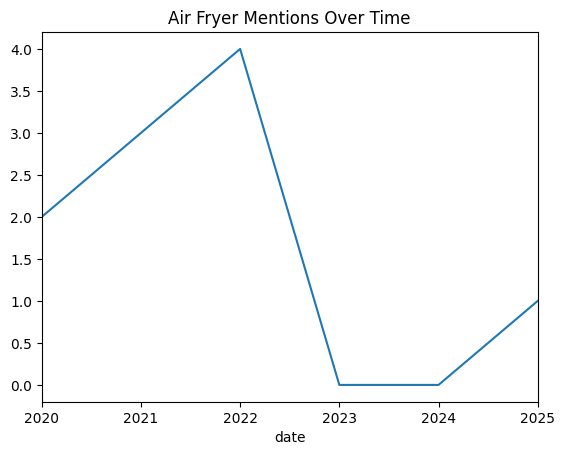

In [20]:
air_fryer = df[df['title'].str.contains('air fryer', case=False, na=False)]
air_fryer.set_index('date').resample('Y').size().plot(title='Air Fryer Mentions Over Time')

/tmp/ipython-input-1465167850.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  feta.set_index('date').resample('Y').size().plot(title='Feta Cheese Mentions Over Time')


<Axes: title={'center': 'Feta Cheese Mentions Over Time'}, xlabel='date'>

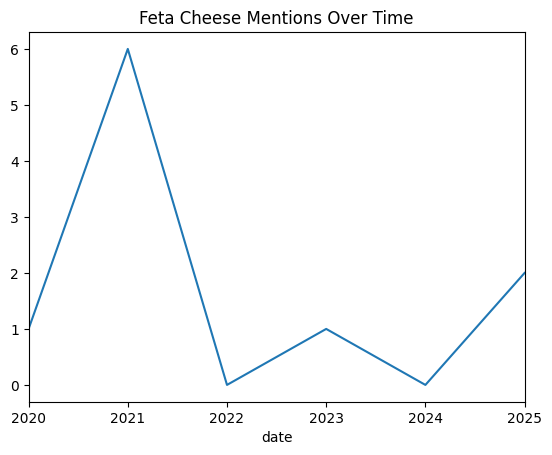

In [21]:
feta = df[df['title'].str.contains('feta', case=False, na=False)]
feta.set_index('date').resample('Y').size().plot(title='Feta Cheese Mentions Over Time')

/tmp/ipython-input-1921045851.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dubai.set_index('date').resample('Y').size().plot(title='Dubai Chocolate Mentions Over Time')


<Axes: title={'center': 'Dubai Chocolate Mentions Over Time'}, xlabel='date'>

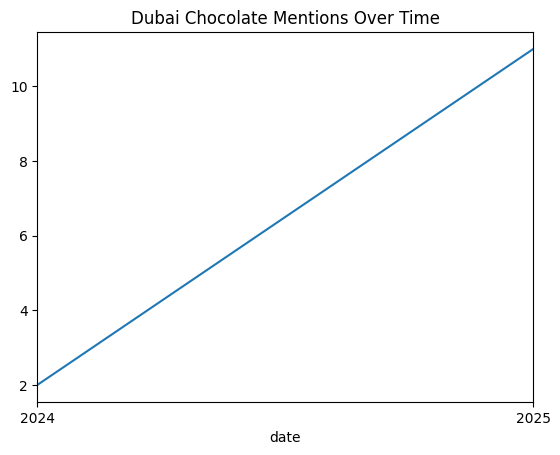

In [22]:
dubai = df[df['title'].str.contains('dubai chocolate', case=False, na=False)]
dubai.set_index('date').resample('Y').size().plot(title='Dubai Chocolate Mentions Over Time')

/tmp/ipython-input-3627766206.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  crumbl.set_index('date').resample('Y').size().plot(title='Crumbl Cookies Mentions Over Time')


<Axes: title={'center': 'Crumbl Cookies Mentions Over Time'}, xlabel='date'>

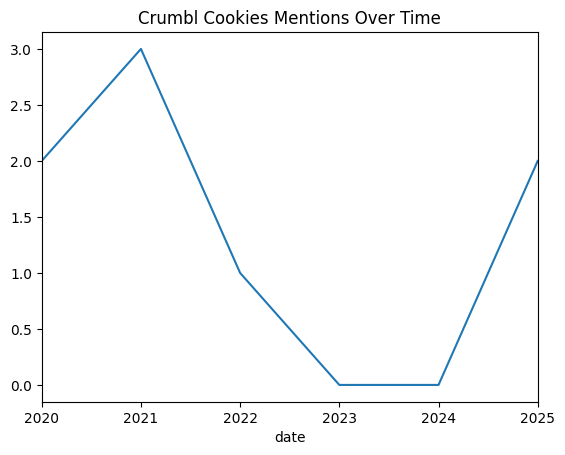

In [23]:
crumbl = df[df['title'].str.contains('crumbl', case=False, na=False)]
crumbl.set_index('date').resample('Y').size().plot(title='Crumbl Cookies Mentions Over Time')

/tmp/ipython-input-3212841451.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  cottage.set_index('date').resample('Y').size().plot(title='Cottage Cheese Mentions Over Time')


<Axes: title={'center': 'Cottage Cheese Mentions Over Time'}, xlabel='date'>

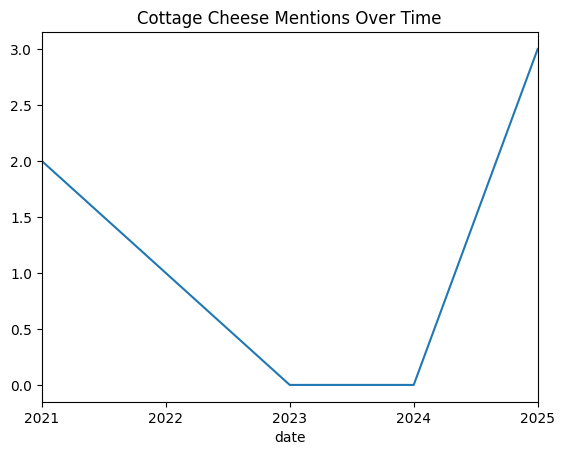

In [24]:
cottage = df[df['title'].str.contains('cottage cheese', case=False, na=False)]
cottage.set_index('date').resample('Y').size().plot(title='Cottage Cheese Mentions Over Time')

ADDING COLUMNS FOR MERGING

In [25]:
# Assuming your main DataFrame is named 'df' and already contains the 'date' column
# that was created from 'created_utc'.

# Convert the 'date' column (which may have time components) to a date-only format (YYYY-MM-DD)
df['Time_Period'] = df['date'].dt.date.astype('datetime64[ns]')

# Check the data type and format
print("--- Time_Period Column Check ---")
print(df[['date', 'Time_Period']].head())
print(f"Time_Period Data Type: {df['Time_Period'].dtype}")

--- Time_Period Column Check ---
                    date Time_Period
2298 2025-10-15 19:31:03  2025-10-15
4211 2025-10-15 16:47:18  2025-10-15
3624 2025-10-15 16:38:24  2025-10-15
6740 2025-10-15 15:23:14  2025-10-15
2569 2025-10-15 15:19:33  2025-10-15
Time_Period Data Type: datetime64[ns]


/tmp/ipython-input-2467897772.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  matcha.set_index('date').resample('Y').size().plot(title='Matcha Mentions Over Time')


<Axes: title={'center': 'Matcha Mentions Over Time'}, xlabel='date'>

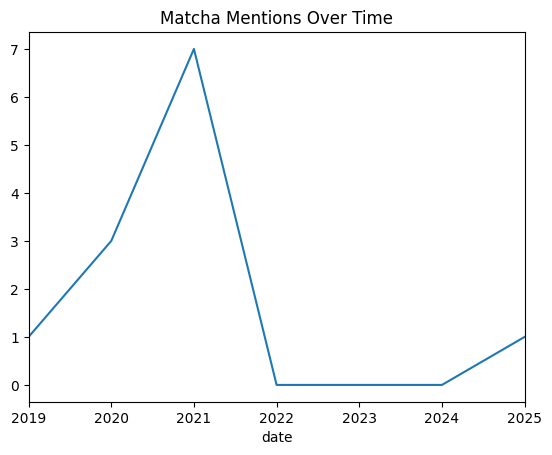

In [26]:
matcha = df[df['title'].str.contains('matcha', case=False, na=False)]
matcha.set_index('date').resample('Y').size().plot(title='Matcha Mentions Over Time')

In [27]:
#create trend id column for dubai chocolate, feta pasta, matcha

In [29]:
# Assuming 'df' is your filtered DataFrame with the 'Time_Period' column

# -----------------------------------------------------------
# 1. Define Keywords and Standardized Trend IDs
# -----------------------------------------------------------
# Create a dictionary mapping the standardized ID to its search keywords
TREND_MAP = {
    'feta-pasta': 'feta pasta|baked feta',
    'matcha': 'matcha|matcha latte|matcha powder',
    'dubai-chocolate': 'dubai chocolate|knafeh chocolate|knafeh'
}

# -----------------------------------------------------------
# 2. Initialize the new column and assign IDs based on title content
# -----------------------------------------------------------

# Initialize the Trend_ID column with a placeholder for posts that don't match any trend
df['Trend_ID'] = 'other'

# Apply the trend IDs in a specific order (e.g., from newest to oldest trend,
# or by which one you want to prioritize if a post mentions two)
# Note: We iterate through the map and assign the ID if the title contains the keywords.

for trend_id, keywords in TREND_MAP.items():
    # Use str.contains to find posts matching the keywords (case-insensitive)
    # The .loc[df['Trend_ID'] == 'other'] ensures we only assign an ID to a post
    # that hasn't already been categorized by a previous trend in the loop.
    df.loc[
        (df['title'].str.contains(keywords, case=False, na=False)) &
        (df['Trend_ID'] == 'other'),
        'Trend_ID'
    ] = trend_id

# -----------------------------------------------------------
# 3. Check the results
# -----------------------------------------------------------
print("--- Check Trend ID Distribution in Main DF ---")
print(df['Trend_ID'].value_counts())
print("\n--- Main DF with New Columns (Sample) ---")
print(df[['title', 'Time_Period', 'Trend_ID']].head(10))

--- Check Trend ID Distribution in Main DF ---
Trend_ID
other              7767
dubai-chocolate      13
matcha               12
feta-pasta            3
Name: count, dtype: int64

--- Main DF with New Columns (Sample) ---
                                                  title Time_Period Trend_ID
2298                                My hoard for winter  2025-10-15    other
4211                                     Spicy Rigatoni  2025-10-15    other
3624  Only posting this due to how proud I am of the...  2025-10-15    other
6740              99 cents each and they’re packed full  2025-10-15    other
2569          Fans after the game between UAE and Qatar  2025-10-15    other
1600                Had Maharaja Mac for the first time  2025-10-15    other
2698                  Uncultured people in dubai metro!  2025-10-15    other
2720  Yall need to keep your ego at home and off the...  2025-10-15    other
6454  Homemade chai using authentic Indian chaiwala ...  2025-10-14    other
3536   fo

In [30]:
print("--- Numerical Summary Statistics (Score & Comments) ---")
print(df[['score', 'num_comments']].describe())

--- Numerical Summary Statistics (Score & Comments) ---
               score  num_comments
count    7795.000000   7795.000000
mean     9189.771777    559.845029
std     17049.010751   1206.998876
min         0.000000      0.000000
25%       300.000000     16.000000
50%       959.000000     78.000000
75%      6971.000000    494.500000
max    156296.000000  24376.000000


In [32]:
df.shape

(7795, 12)

/tmp/ipython-input-4211931349.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


Generated plot for dubai-chocolate vs matcha.
Generated plot for matcha vs feta-pasta.
Generated plot for dubai-chocolate vs feta-pasta.


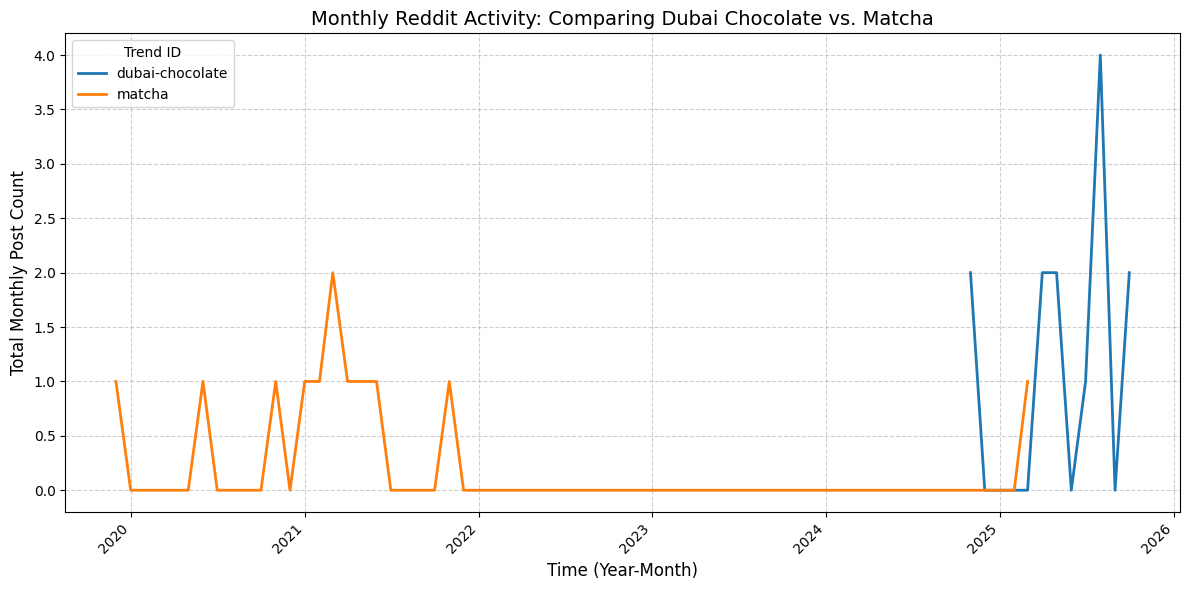

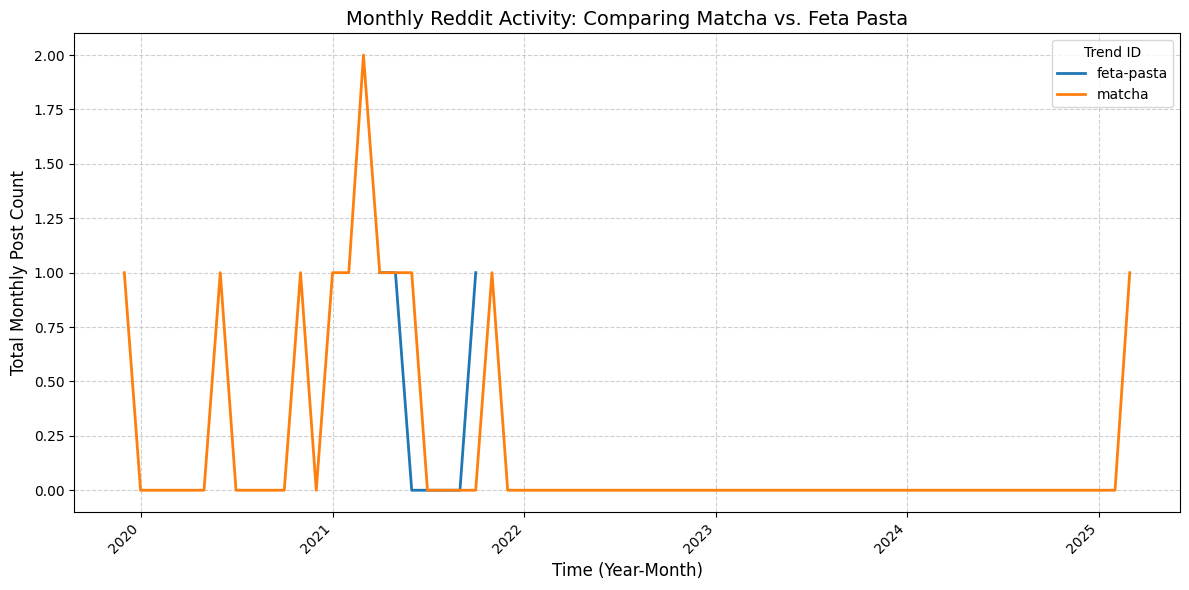

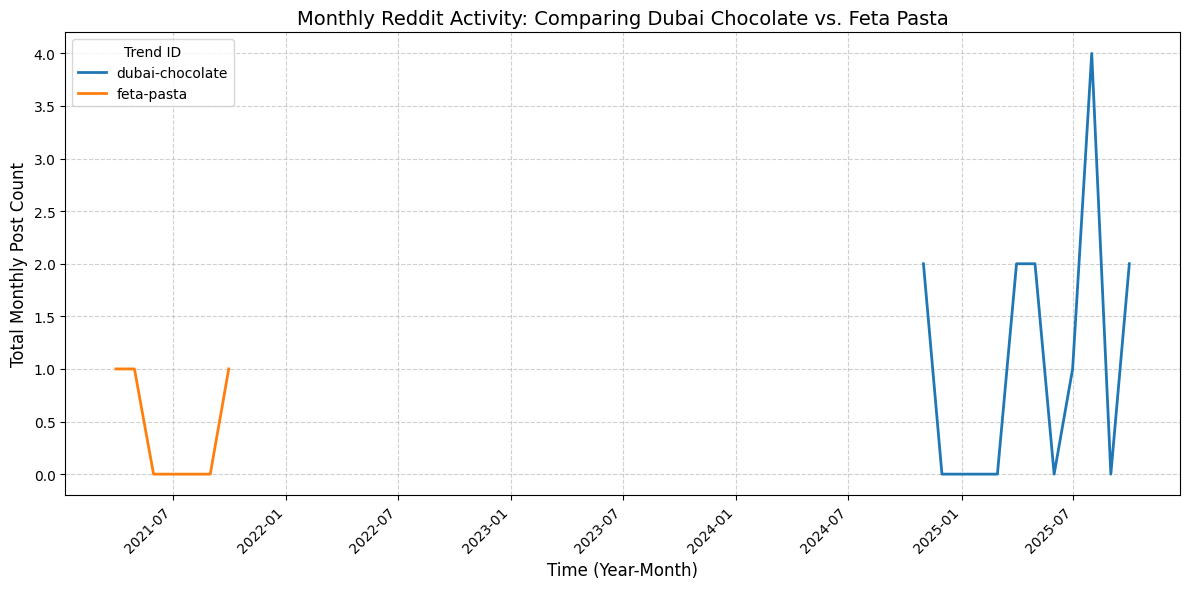

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is the filtered DataFrame (2015-2025) with 'Time_Period' and 'Trend_ID' columns

# ----------------------------------------------------------------------
# 1. Prepare Monthly Aggregated Data (Runs only once)
# ----------------------------------------------------------------------

# Filter to include only the three target trends
target_trends_df = df[df['Trend_ID'].isin(['feta-pasta', 'matcha', 'dubai-chocolate'])].copy()

if target_trends_df.empty:
    print("Error: No data found for the target trends. Please ensure the 'Trend_ID' column was created correctly.")
else:
    # Group by Time_Period (daily) and Trend_ID and count the posts
    daily_activity = target_trends_df.groupby(['Time_Period', 'Trend_ID']).size().reset_index(name='post_count')
    daily_activity = daily_activity.set_index('Time_Period')

    # Resample the daily data to monthly frequency
    monthly_activity = (
        daily_activity.groupby('Trend_ID')['post_count']
        .resample('M')
        .sum()
        .fillna(0)
        .reset_index()
    )

    # ----------------------------------------------------------------------
    # 2. Generate Duo-Plots
    # ----------------------------------------------------------------------

    # Define the trend pairs for iteration
    trend_pairs = [
        ('dubai-chocolate', 'matcha'),
        ('matcha', 'feta-pasta'),
        ('dubai-chocolate', 'feta-pasta')
    ]

    for trend1, trend2 in trend_pairs:
        # Filter the monthly data for only the two current trends
        comparison_df = monthly_activity[monthly_activity['Trend_ID'].isin([trend1, trend2])]

        plt.figure(figsize=(12, 6))
        sns.lineplot(
            data=comparison_df,
            x='Time_Period',
            y='post_count',
            hue='Trend_ID',
            linewidth=2
        )

        # Set titles and labels
        title = f'Monthly Reddit Activity: Comparing {trend1.replace("-", " ").title()} vs. {trend2.replace("-", " ").title()}'
        plt.title(title, fontsize=14)
        plt.ylabel('Total Monthly Post Count', fontsize=12)
        plt.xlabel('Time (Year-Month)', fontsize=12)
        plt.legend(title='Trend ID', title_fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()

        # Save the figure
        plt.savefig(f'{trend1}_vs_{trend2}_monthly.png')
        print(f"Generated plot for {trend1} vs {trend2}.")